# 思路

## 应用场景

检测海报中出现的物体，探索物体之间的关联性，形成设计的“物体图谱”。
比如对于设计师来说，搜索“自行车”，就可以看到哪些物体是和自行车同时出现的，方便寻找足够多的设计元素。

## 架构图

![framework](https://raw.githubusercontent.com/zhuojg/hacking-design-ai-2020/master/images/framework_level02-2.png)

## 实现思路

1. 通过关键字爬取一定数量的海报
2. 使用imageai识别图像中的物体
3. 将物体作为图中的节点，物体在同一张海报中出现则新增一条边，以此构建图谱

## 注意

使用imageai库需要tensorflow==1.14，预训练模型下载参考：https://github.com/OlafenwaMoses/ImageAI/blob/master/imageai/Detection/README.md

In [ ]:
# lib import
import os
import networkx as nx
from imageai.Detection import ObjectDetection
from pyppeteer import launch
import requests
import matplotlib.pyplot as plt

In [4]:
# utils
detector = ObjectDetection()
# 根据情况选择模型，模型参考及与训练模型下载：
# https://github.com/OlafenwaMoses/ImageAI/blob/master/imageai/Detection/README.md
detector.setModelTypeAsYOLOv3()
detector.setModelPath('../external_lib/yolo.h5')
detector.loadModel()

def get_objects(img_path):
    _, detections = detector.detectObjectsFromImage(output_type="array", input_image=img_path, minimum_percentage_probability=50)
    
    result = []
    for eachObject in detections:
        result.append(eachObject['name'])
    
    return result

In [5]:
#注入js代码，获取页面里所有图片url
#配合chrome的console演示
async def get_imgs(page, keyword):
    imgs = await page.evaluate('''() => {
            return Array.from(document.images,img=>{
                    if(img.alt.match('%s')&&img.src.match('https://')){
                        return img.src;
                    }
                }).filter(img=>{return !!img});
        }''' % keyword)
    return imgs

# 根据输入关键字，在Bing上获取对应图像
async def get_data_from_keywords(keywords):
    all_images = {}
    
    for item in keywords:
        images = {}
        url = 'https://cn.bing.com/images/search?q=%s' % item
        browser = await launch(headless=True)
        page = await browser.newPage()
        await page.goto(url)
        
        #页面等待时间,ms, 
        await page.waitFor(2500)
        
        #当图片数量大于 100的时候，停止
        while len(images) < 100:
            imgs = await get_imgs(page, item)
            #python 列表，javscript 数组
            # ["http://www","xxxx","xxxx"]
            for img in imgs:
                #字典，如何赋值
                images[img] = 1

            await page.evaluate('''() => {
                    return window.scrollTo(100,document.body.scrollHeight);
                }''')
            print(len(images))
            await page.waitFor(2500)


        #关闭浏览器
        await browser.close()
        
        all_images[item] = images
    
    return all_images

In [ ]:
keywords = ['美食海报', '端午海报', '父亲节海报', '宇宙海报', '疫情海报']

all_images = await get_data_from_keywords(keywords)

In [ ]:
data_path = './data'

def download_img(img_url,file_path):
    r = requests.get(img_url, stream=True)
    if r.status_code == 200:
        open(file_path, 'wb').write(r.content) # 将内容写入图片
    del r

for keyword in all_images.keys():
    keyword_dir = os.path.join(data_path, keyword)
    if not os.path.exists(keyword_dir):
        os.mkdir(keyword_dir)
    
    for i, item in enumerate(all_images[keyword].keys()):
        download_img(item, os.path.join(keyword_dir, '%d.png' % i))

In [13]:
# 遍历文件夹，获取所有图片
def get_all_image(path):
    image_list = []
    for item in os.listdir(path):
        item_path = os.path.join(path, item)
        if os.path.isfile(item_path):
            image_list.append(item_path)
        else:
            image_list.extend(get_all_image(item_path))

    return image_list

image_list = get_all_image('./data')

In [ ]:
# data preprocess
# 使用打包好的get_objects函数，识别海报中的对象
objects_group = []

for i, item in enumerate(image_list):
    temp_result = get_objects(item)
    objects_group.append(temp_result)
    
    if i % 10 == 0:
        print('%d / %d' % (i, len(image_list)))

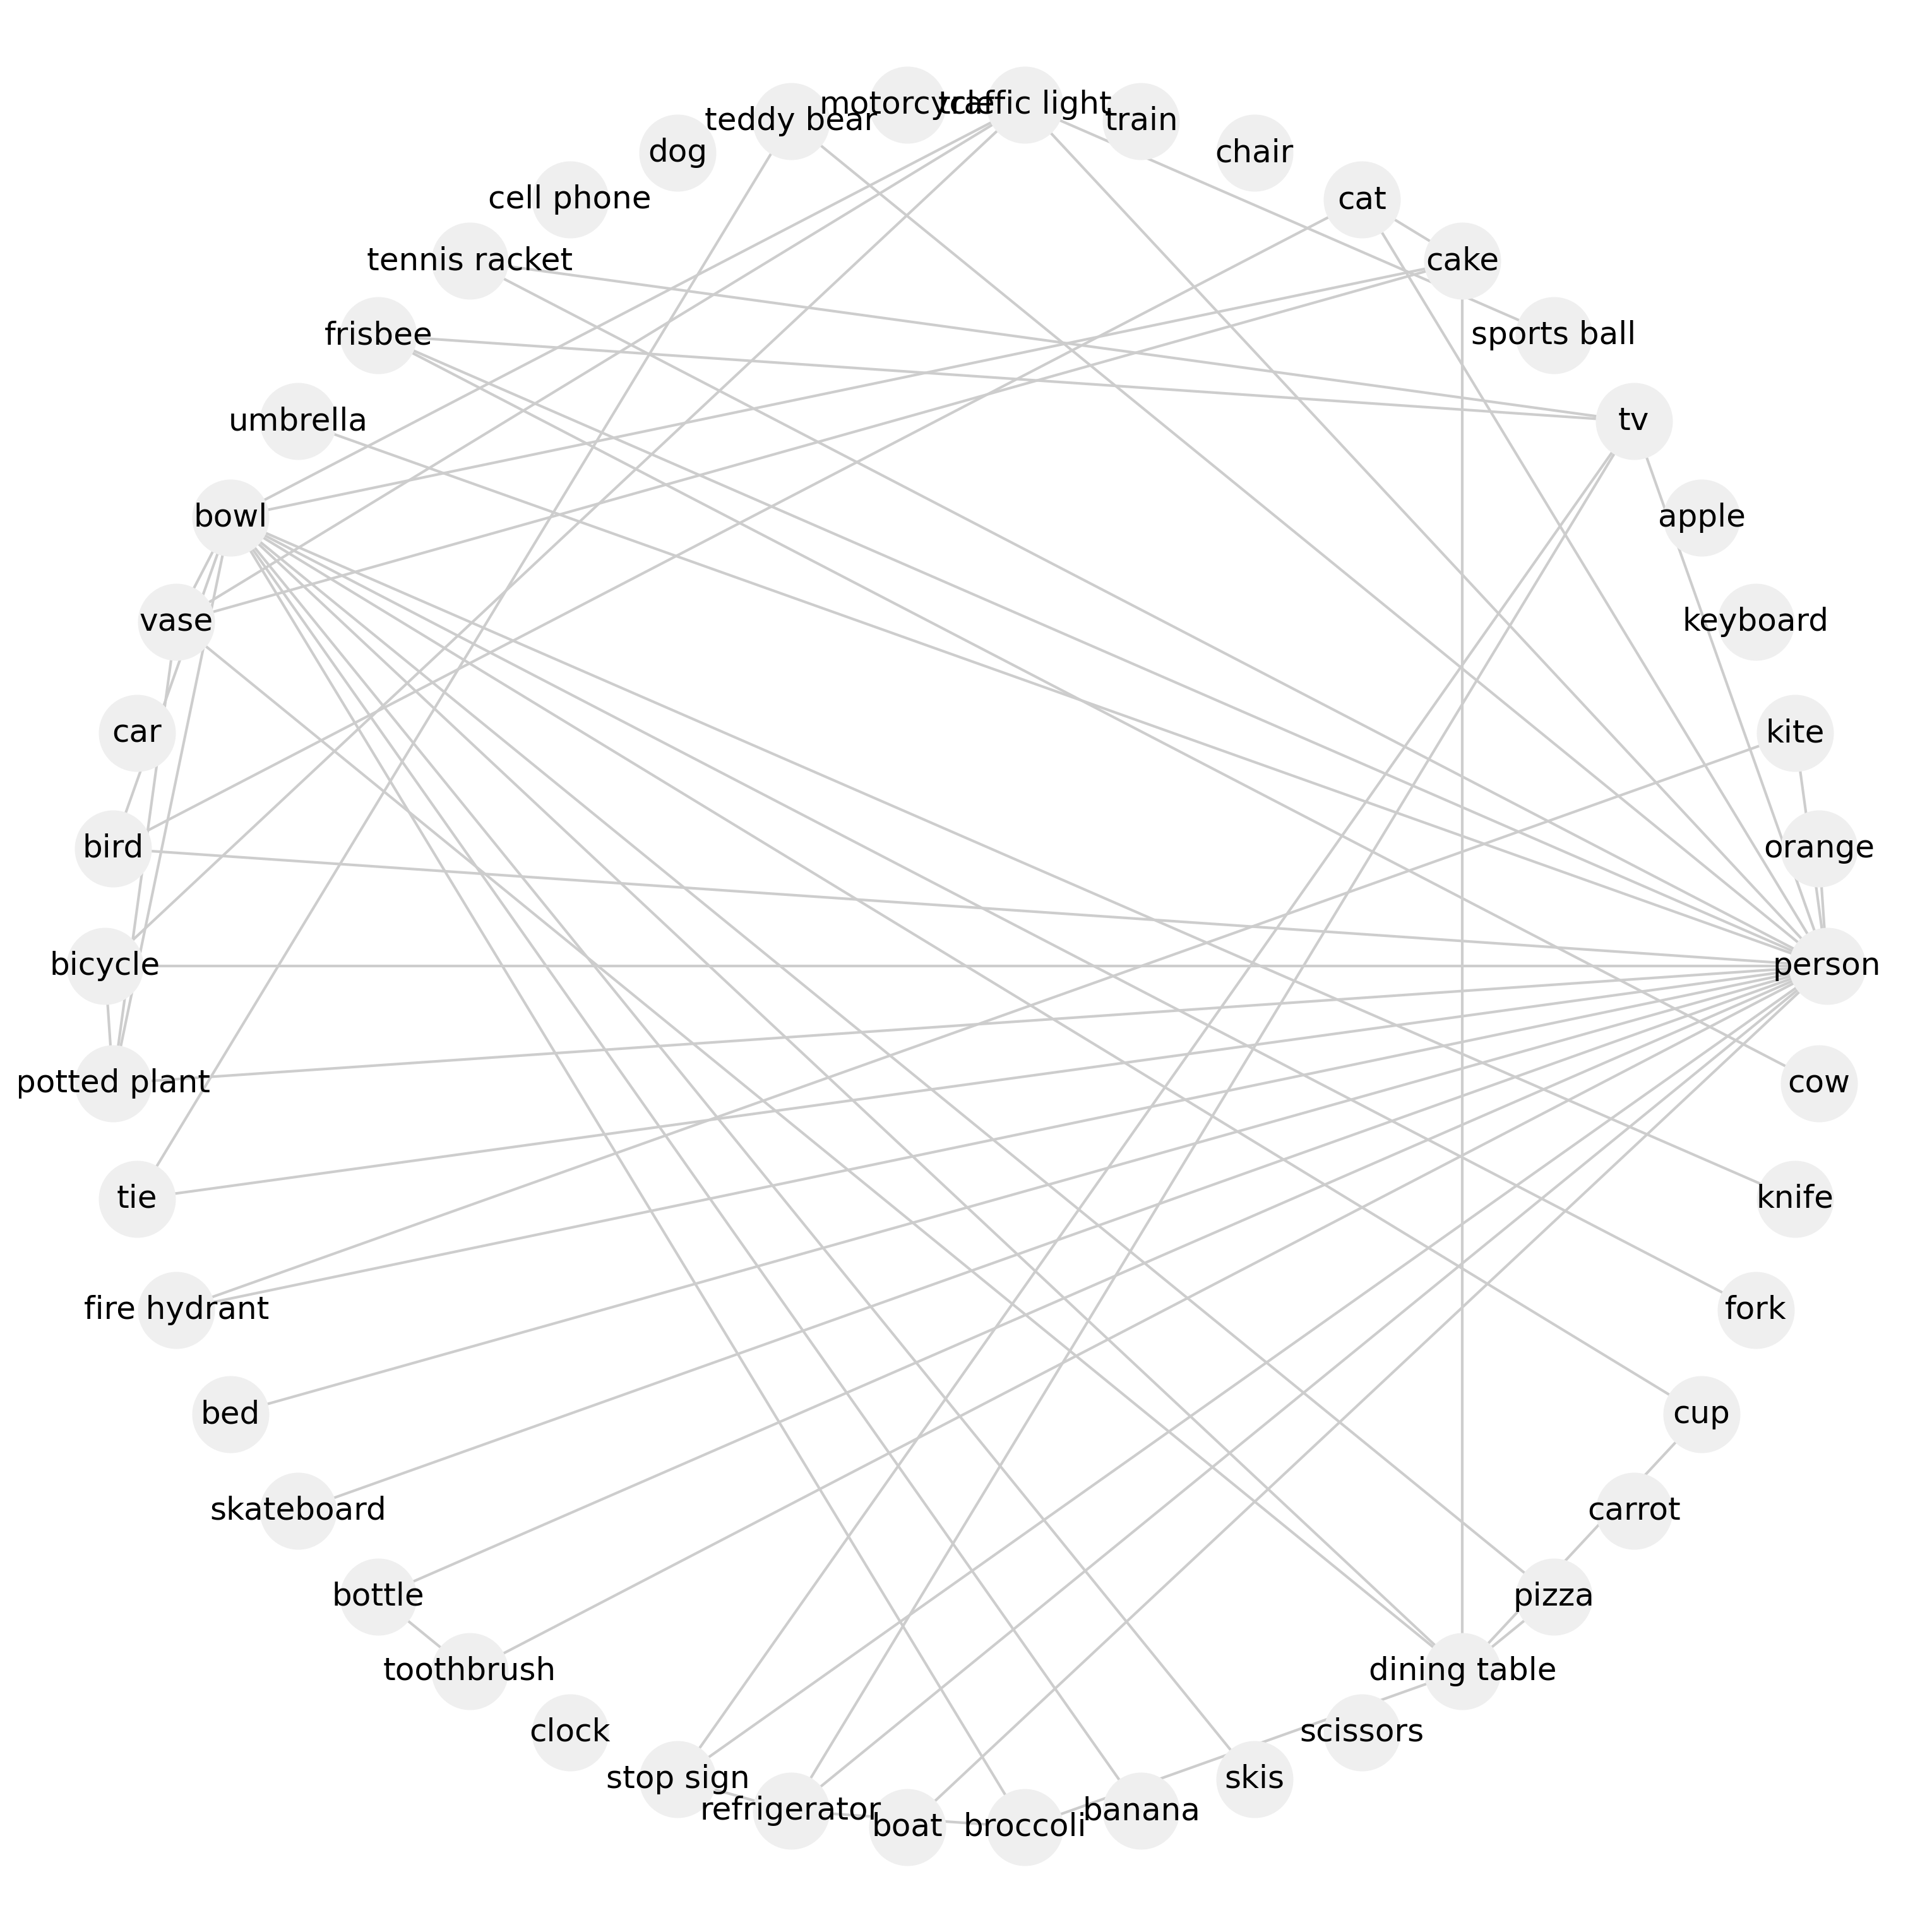

In [53]:
# graph generate
G = nx.Graph()

for group in objects_group:
    G.add_nodes_from(group)
    for i, item in enumerate(group):
        for j in range(i + 1, len(group)):
            G.add_edge(item, group[j])

plt.figure(figsize=(10, 10))
plt.rcParams['figure.dpi'] = 300 #分辨率

nx.draw_shell(G, with_labels=True, node_size=800,node_color='#efefef', edge_color='#cdcdcd')